In [1]:
!pip install pykalman

     |████████████████████████████████| 228 kB 4.3 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=28968722fcb87084b204f0c64f1ecf8d82ff9685e9b09a4a3513a6d42621d1f9
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman


In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from pykalman import KalmanFilter

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# data path is 'data/trial-1'
data_path = 'data'
# get cluster_1 fron .npy file
cluster_1 = np.load(data_path + '/cluster_0.npy')
print(cluster_1.shape)

(49500, 15)


In [38]:
# remove nan values from the cluster_1[:, 0]
cluster_1 = cluster_1[~np.isnan(cluster_1[:, 100])]
print(cluster_1.shape)


(0, 1681)


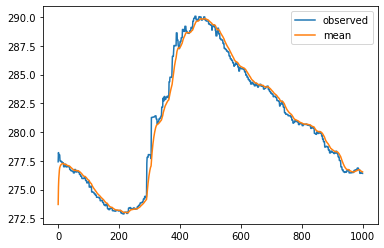

In [7]:
# Construct a Kalman filter for the data
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 270,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Use the observed values of the data to get a rolling mean
state_means, _ = kf.filter(cluster_1[:1000, 0])

# plot the data and the mean
plt.plot(cluster_1[:1000, 0], label='observed')
plt.plot(state_means, label='mean')
plt.legend()
plt.show()


# https://github.com/johannaSommer/KF_irreg_TS/blob/main/notebooks/KF_example.ipynb

In [8]:
!git clone https://github.com/johannaSommer/KF_irreg_TS.git

Cloning into 'KF_irreg_TS'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 44 (delta 9), reused 40 (delta 8), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os
os.chdir('..')
from KF_irreg_TS.models.disc_kalman_filter import DiscreteKalmanFilter

plt.rcParams["figure.figsize"] = (20,10)

In [10]:
t = np.linspace(0, 10, 100)
y = np.stack([np.sin(t), np.cos(t)]).T + np.random.normal(0, 0.1, (100, 2))
print(y.shape)

(100, 2)


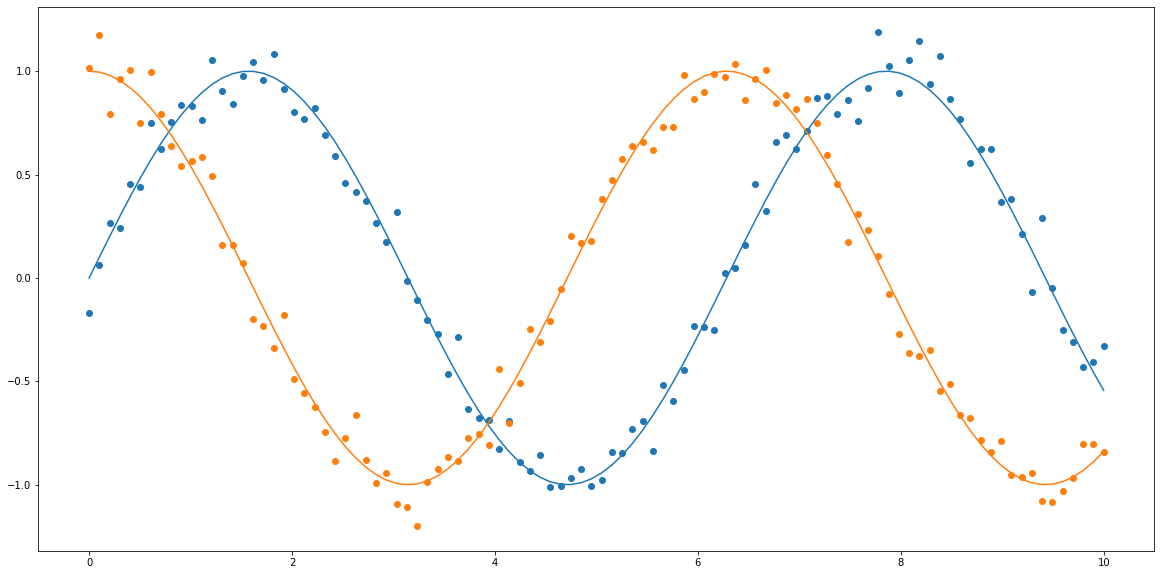

In [11]:
mask = torch.ones_like(torch.Tensor(y))
plt.scatter(t, y[:,0])
plt.scatter(t, y[:,1])
plt.plot(t, np.sin(t))
plt.plot(t, np.cos(t))
plt.show()

In [12]:
model = DiscreteKalmanFilter(dim=2, latent_dim=8)
optim = torch.optim.Adam(model.parameters())

for i in range(1, 501):
    optim.zero_grad()
    loss = model(torch.Tensor(y))
    if i % 100 == 0:
        print(f'Iter {i}, loss: {loss:.4f}')
    loss.backward()
    optim.step()

/content/KF_irreg_TS/models/disc_kalman_filter.py:75: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).transpose(-2, -1).conj().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1285.)
  L = torch.cholesky(pred_sigma)


Iter 100, loss: 1.0489
Iter 200, loss: 0.7330
Iter 300, loss: 0.5486
Iter 400, loss: 0.3261
Iter 500, loss: 0.0150


In [13]:
pred_mu_1, pred_sigma_1, x, P = model.iterate_disc_sequence(torch.Tensor(y))

In [14]:
print(x.shape)

torch.Size([8, 1])


In [15]:
pred_mu_2, pred_sigma_2 = model.forecasting(100, x, P)        
pred_mu = torch.cat([pred_mu_1, pred_mu_2]).detach().cpu().numpy()
pred_sigma = torch.cat([pred_sigma_1, pred_sigma_2]).detach().cpu().numpy()

In [17]:
print(pred_mu.shape)

(200, 2)


In [18]:
print(pred_sigma.shape)

(200, 2, 2)


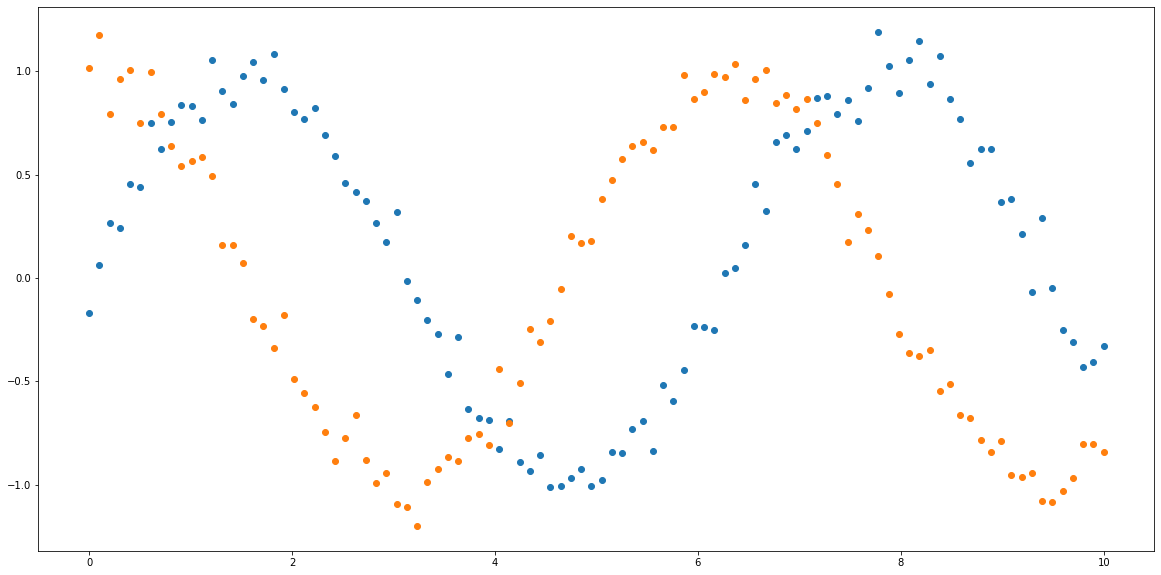

In [16]:
plt.scatter(t, y[:,0], c='C0')
plt.scatter(t, y[:,1], c='C1')

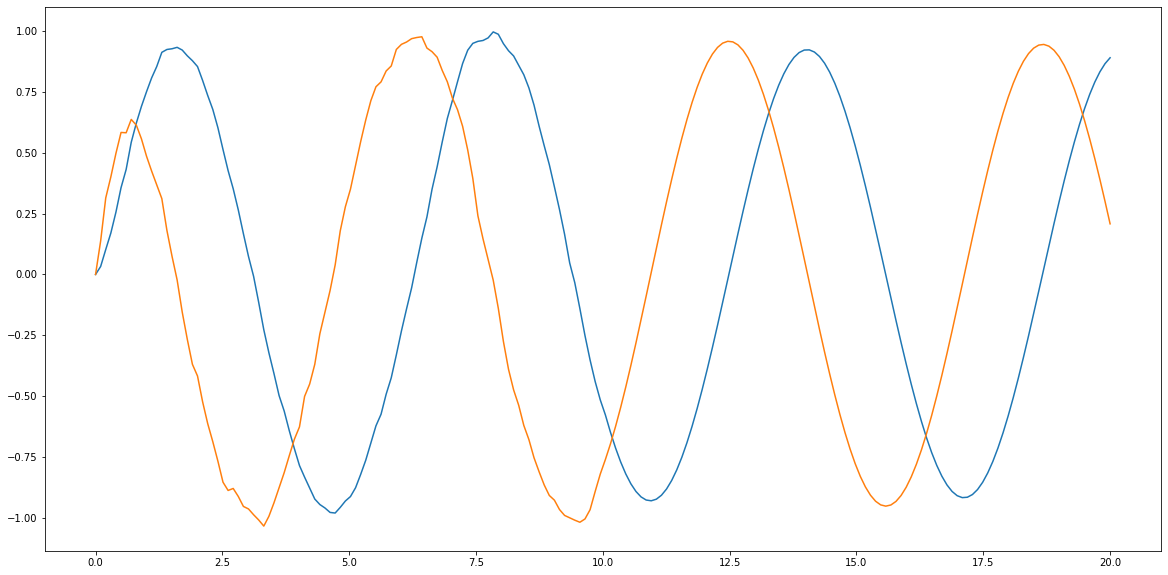

In [19]:
plt.plot(np.linspace(0, 20, 200), pred_mu[:,0], c='C0')
plt.plot(np.linspace(0, 20, 200), pred_mu[:,1], c='C1')

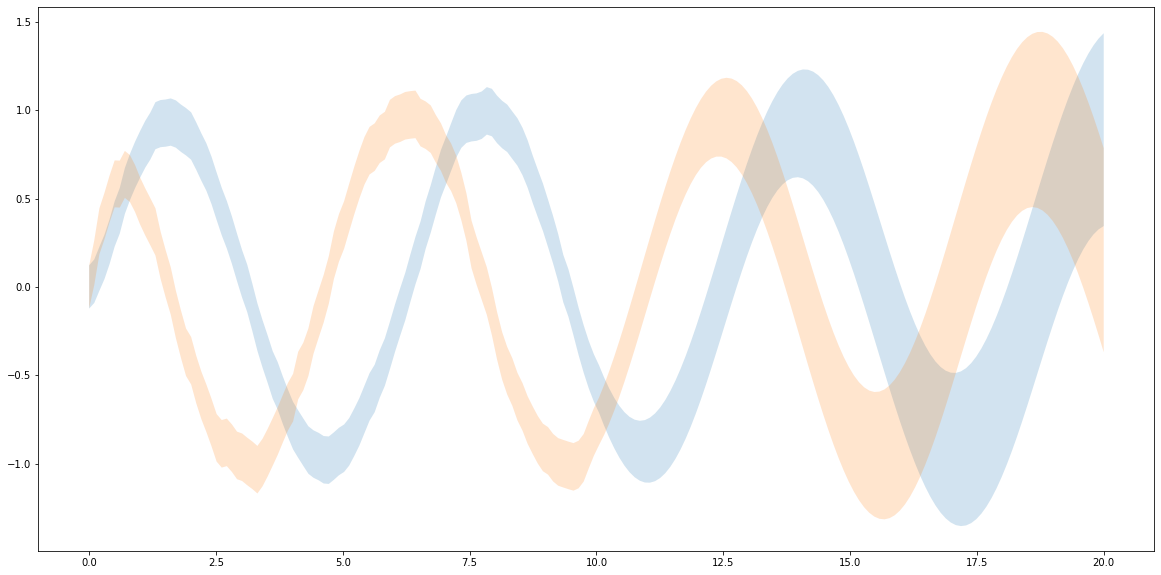

In [20]:
plt.fill_between(np.linspace(0, 20, 200), pred_mu[:,0] - pred_sigma[:,0,0], pred_mu[:,0] + pred_sigma[:,0,0], alpha=0.2)
plt.fill_between(np.linspace(0, 20, 200), pred_mu[:,1] - pred_sigma[:,1,1], pred_mu[:,1] + pred_sigma[:,1,1], alpha=0.2)


# Discrete Kalman Filter on Cluster

In [22]:
cluster_1.shape

(49500, 15)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os
os.chdir('..')
from KF_irreg_TS.models.disc_kalman_filter import DiscreteKalmanFilter

plt.rcParams["figure.figsize"] = (20,10)

In [25]:
y = cluster_1[:100, 0]
# reshape y to be a 2D
y = y.reshape(-1, 1)
print(y.shape)

(100, 1)


In [26]:
mask = torch.ones_like(torch.Tensor(y))

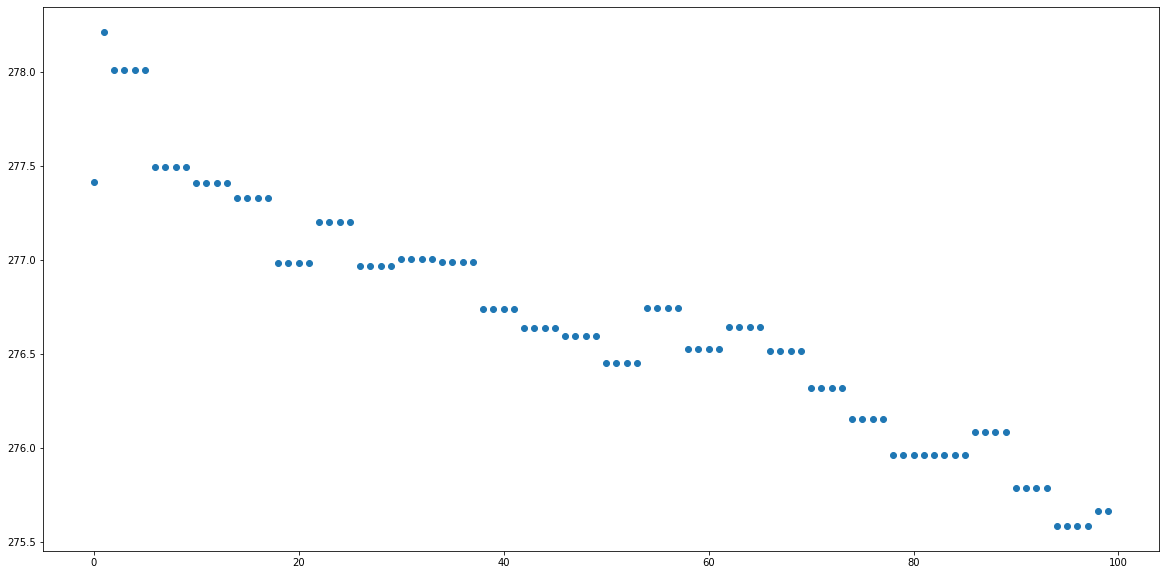

In [28]:
# get a scatter plot of y 
plt.scatter(np.arange(y.shape[0]), y)
plt.show()

In [30]:
model = DiscreteKalmanFilter(dim=1, latent_dim=8)
optim = torch.optim.Adam(model.parameters())

for i in range(1, 501):
    optim.zero_grad()
    loss = model(torch.Tensor(y))
    if i % 100 == 0:
        print(f'Iter {i}, loss: {loss:.4f}')
    loss.backward()
    optim.step()

Iter 100, loss: 754.5391
Iter 200, loss: 684.8793
Iter 300, loss: 624.7603
Iter 400, loss: 569.7018
Iter 500, loss: 520.9656


In [31]:
pred_mu_1, pred_sigma_1, x, P = model.iterate_disc_sequence(torch.Tensor(y))
pred_mu_2, pred_sigma_2 = model.forecasting(10, x, P)        
pred_mu = torch.cat([pred_mu_1, pred_mu_2]).detach().cpu().numpy()
pred_sigma = torch.cat([pred_sigma_1, pred_sigma_2]).detach().cpu().numpy()
print(pred_mu.shape)

(110, 1)


In [ ]:
plt.scatter(np.arange(y.shape[0]), y)
# plot the pred_mu 
plt.plot(np.arange(y.shape[0], y.shape[0]+10), pred_mu, c='C0')

plt.fill_between(np.arange(y.shape[0], y.shape[0]+10), pred_mu[:,0] - pred_sigma[:,0,0], pred_mu[:,0] + pred_sigma[:,0,0], alpha=0.2)
plt.plot()
plt.show()

In [ ]:
# Plot the data and the mean
plt.scatter(np.arange(y.shape[0]), y)
plt.plot(np.arange(y.shape[0], y.shape[0]+10), pred_mu, c='C0')
plt.fill_between(np.arange(y.shape[0], y.shape[0]+10), pred_mu[:,0] - pred_sigma[:,0,0], pred_mu[:,0] + pred_sigma[:,0,0], alpha=0.2)
plt.show()


In [ ]:
# plot 